In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import camb
from camb import model, initialpower

In [17]:
""" maybe we can move most of this code to some kind of
models.py that we import. This would be justified
because these are typical test models, so I imagine
that we will be returning to them many times in the
future. """

#constants
ombh2 = 0.022445
n_s = 0.96

#baselines
sig8_b = 0.82755
# Lbox_b = 1000 # I don't think CAMB has this
wa_b = 0.00
w0_b = -1.00
OmK_b = 0
OmL_b = 0.681415906
omch2_b = 0.120567
mnu_b = 0.00
h_b = 0.67
# derived quantities
H0_b = 100 * h_b

omega_nu = [0.0006356, 0.002, 0.006356]

baseline = {
    "H0": H0_b,
    "ombh2": ombh2,
    "omch2": omch2_b,
    "omk": OmK_b,
    "tau": 0.06, # not specified by provided data table
    "w": w0_b,
    "wa": wa_b,
    "ns": 0.96
}
As = [
    2.12723788013000E-09,
    1.78568440085517E-09,
    2.48485942677850E-09,
    2.32071013846548E-09,
    1.99553701204688E-09,
    2.07077004294502E-09,
    2.20196413682945E-09,
    1.92961581654148E-09,
    2.29291725000000E-09
]

cosm = [] # cosmologies
# This order ensures that the indices are the same
# before and after applying CAMB.
redshifts = [4, 3, 2, 1, 0]

In [18]:
for i in range(9):
    cosm.append(baseline.copy())
    cosm[i]["As"] = As[i]
    
cosm[1]["H0"] = 55
cosm[2]["H0"] = 79

""" (end of proposed models.py shin-dig) """

' (end of proposed models.py shin-dig) '

In [19]:
def kzps(mlc, omnuh2_in, massive_neutrinos=False, sigma12_in=1, zs = [0]):
    """
    Returns the scale axis, redshifts, power spectrum, and sigma12
    of a Lambda-CDM model
    @param mlc : "MassLess Cosmology"
        a dictionary of values
        for CAMBparams fields
    @param omnuh2_in : neutrino physical mass density
    @param sigma12 : if the spectrum should be rescaled,
        this parameter determines the desired sigma12 of the model
    @massive_neutrinos : if this is True,
        the value in omnuh2_in is used to set omnuh2.
        If this is False,
        the value in omnuh2_in is simply added to omch2.
    """
    pars = camb.CAMBparams()
    omch2_in = mlc["omch2"]
    if massive_neutrinos:
        omch2_in = mlc["omch2"] - omnuh2_in
        pars.omnuh2=omnuh2_in
    pars.set_cosmology(
        H0=mlc["H0"],
        ombh2=mlc["ombh2"],
        omch2=omch2_in,
        omk=mlc["omk"],
        tau=mlc["tau"])
    pars.InitPower.set_params(As=mlc["As"], ns=mlc["ns"])
    pars.set_dark_energy(w=mlc["w"], wa=mlc["wa"])
    
    pars.set_matter_power(redshifts=zs, kmax=2.0)
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    results.calc_power_spectra(pars)
    
    if sigma12_in != 1:
        sigma12_unmodified = results.get_sigmaR(12, hubble_units=False)
        As_rescaled = 2e-9 * (sigma12_in / sigma12_unmodified) ** 2

        pars.InitPower.set_params(As=As_rescaled, ns=mlc["ns"])

    k, z, p = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)
    sigma12 = results.get_sigmaR(12, hubble_units=False)
    return k, z, p, sigma12

In [20]:
# Let us begin our demonstration by considering only the
# middle of the
# given neutrino mass physical densities, omega_nu[1]
k_massless_list = []
z_massless_list = []
p_massless_list = []
s12_massless_list = []

k_massive_list = []
z_massive_list = []
p_massive_list = []
s12_massive_list = []

for cosmology in cosm:
    k, z, p, s12 = kzps(cosmology, omega_nu[1], massive_neutrinos=False,
                       zs=redshifts)
    k_massless_list.append(k)
    z_massless_list.append(z)
    p_massless_list.append(p)
    s12_massless_list.append(s12)
    
    k, z, p, s12 = kzps(cosmology, omega_nu[1], massive_neutrinos=True,
                       zs=redshifts)
    k_massive_list.append(k)
    z_massive_list.append(z)
    p_massive_list.append(p)
    s12_massive_list.append(s12)

#kmassive, zmassive, pmassive, sigma12 = kzps(cosm[0], omega_nu[1], massive_neutrinos=True)
#kmassless, zmassless, pmassless, sigma12 = kzps(cosm[0], omega_nu[1], massive_neutrinos=False)

In [21]:
colors = ["green", "blue", "brown"]

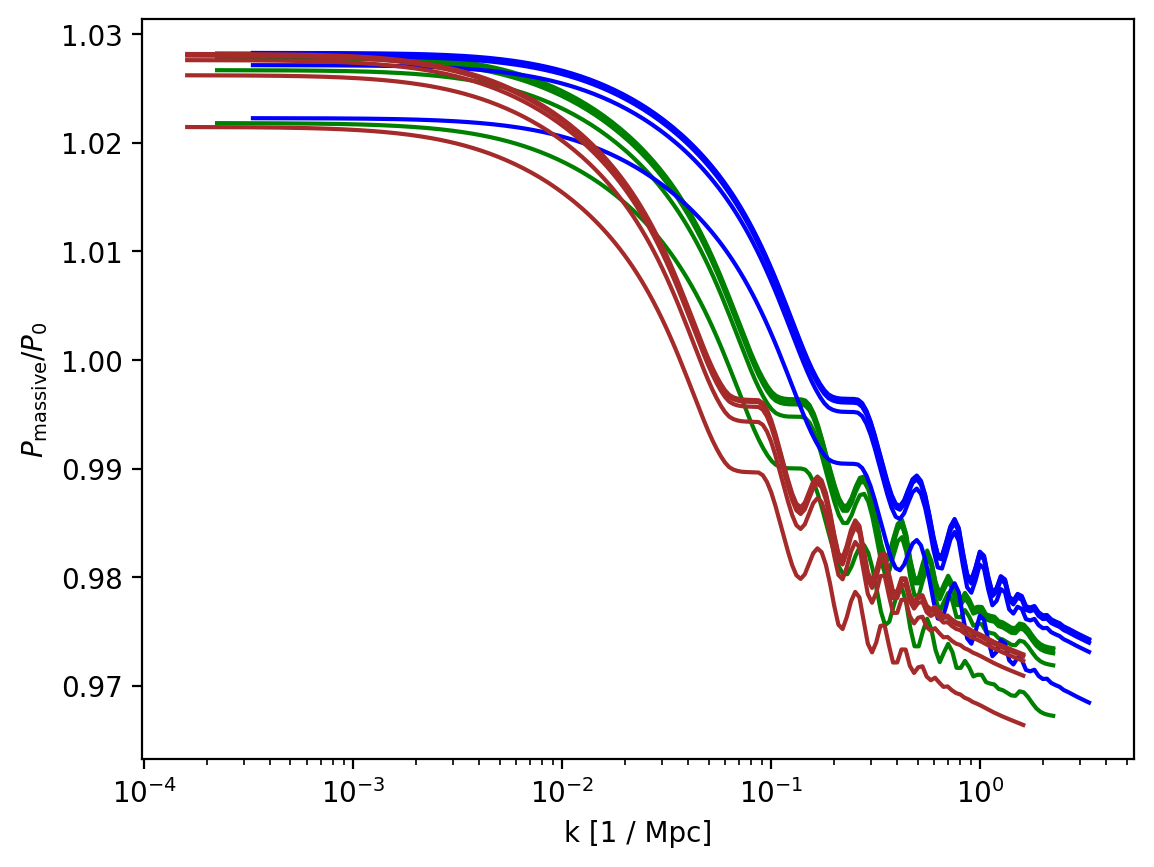

In [22]:
for i in range(0, 3):
    h = cosm[i]["H0"] / 100
    for j in range(5):
        plt.plot(k_massless_list[i] / h ** 2, p_massive_list[i][j] / p_massless_list[i][j],
                 label="model " + str(i) + ", no renormalizing",
                c=colors[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    #plt.legend()

0.67
0.55
0.79


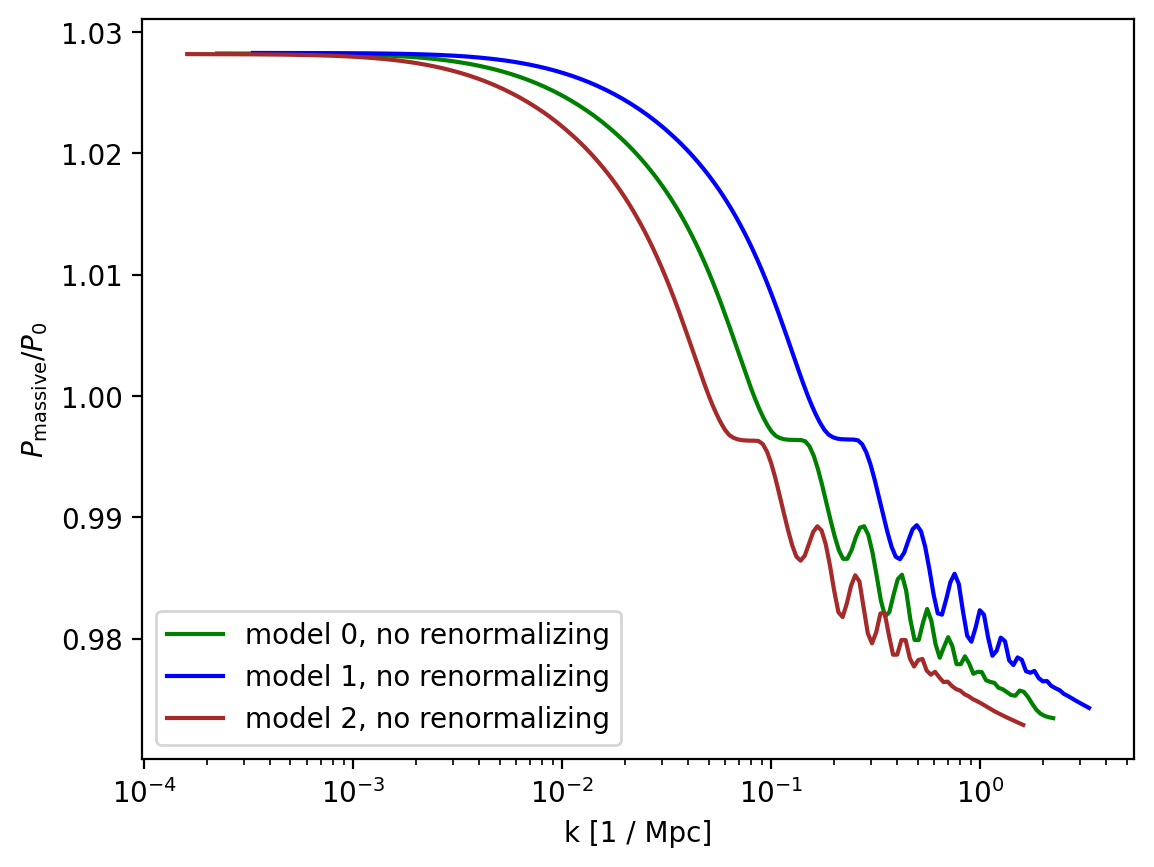

In [23]:
for i in range(0, 3):
    h = cosm[i]["H0"] / 100
    print(h)
    j = 4 # just look at z=0 before moving on
    plt.plot(k_massless_list[i] / h ** 2, p_massive_list[i][j] / p_massless_list[i][j],
                 label="model " + str(i) + ", no renormalizing",
                c=colors[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.legend()

Problems? and problems:
* Ariel's x-axis has 1 / Mpc, but mine has h / Mpc.
    * I think I've fixed this problem by dividing my result by h^2
* I am currently not re-normalizing the amplitude of one model mased on its counterpart. At least, I *think* I'm not doing that.
* I need to set a k_min value so that the x axes align better